In [1]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
session=sagemaker.Session()
role=get_execution_role()


In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
bostondata = load_boston()
X,y=pd.DataFrame(bostondata.data,columns=bostondata.feature_names),pd.DataFrame(bostondata.target)

In [14]:
X.shape

(506, 13)

In [ ]:
# !mkdir data

In [24]:
# Convert data to make it kosher for sagemaker
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.33)
pd.concat([y_train,X_train],axis=1).to_csv('data/train.csv',header=False,index=False)
pd.concat([y_val,X_val],axis=1).to_csv('data/validation.csv',header=False,index=False)
X_test.to_csv('data/test.csv',header=False,index=False)

In [4]:
# upload to S3
prefix='boston-xgboost-HL'
session.upload_data('data',key_prefix=prefix)

In [5]:
# !pip uninstall -f sagemaker
# !pip install sagemaker==1.72.0
sagemaker.__version__

'1.72.0'

In [6]:
# for latest sagemaker >2 
# container=sagemaker.image_uris.retrieve('xgboost',session.boto_region_name)
container=get_image_uri(session.boto_region_name,'knn')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [7]:
xgb=sagemaker.estimator.Estimator(container,
                                  get_execution_role(),
                                 train_instance_count=1,
                                 train_instance_type='ml.m5.large',
                                 output_path='s3://sagemaker-us-east-1-032934527328/boston-xgboost-HL/output',
                                 sagemaker_session=session,
                                train_use_spot_instances=True,
                                  train_max_wait=3600,train_max_run=3600
                                 )

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [15]:
# xgb.set_hyperparameters(max_depth=5,
#                        eta=0.2,
#                        gamma=4,
#                        min_child_weight=6,
#                        subsample=0.8,
#                        objective='reg:linear',
#                        early_stopping_rounds=10,
#                        num_round=200)


# hyperparams = {"feature_dim": 54, "k": 10, "sample_size": 200000, "predictor_type": "classifier"}
xgb.set_hyperparameters(feature_dim=13 , k= 10, sample_size= 200000, predictor_type= "regressor")

In [16]:
# Wrapper so sagemaker knows data is in csv
#xgboost content_type='csv' knn content_type='text/csv'
# s3_input_train=sagemaker.s3_input(s3_data='s3://sagemaker-us-east-1-032934527328/boston-xgboost-HL/train.csv',
#                                   content_type='csv')
# s3_input_validation=sagemaker.s3_input(s3_data='s3://sagemaker-us-east-1-032934527328/boston-xgboost-HL/validation.csv',
#                                   content_type='csv')

s3_input_train=sagemaker.s3_input(s3_data='s3://sagemaker-us-east-1-032934527328/boston-xgboost-HL/train.csv',
                                  content_type='text/csv')
s3_input_validation=sagemaker.s3_input(s3_data='s3://sagemaker-us-east-1-032934527328/boston-xgboost-HL/validation.csv',
                                  content_type='text/csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [17]:
xgb.fit({'train':s3_input_train,'validation':s3_input_validation})

2021-04-09 17:19:50 Starting - Starting the training job...
2021-04-09 17:19:52 Starting - Launching requested ML instances......
2021-04-09 17:21:08 Starting - Preparing the instances for training......
2021-04-09 17:22:10 Downloading - Downloading input data...
2021-04-09 17:22:33 Training - Downloading the training image...
2021-04-09 17:23:20 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[04/09/2021 17:23:13 INFO 140625953760640] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'index_metric': u'L2', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'feature_dim': u'auto', u'faiss_index_ivf_nlists': u'auto', u'epochs': u'1', u'index_type': u'faiss.Flat', u'_faiss_index_nprobe': u'5', u'_kvstore': u'dist_async', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000'}
[04/09/2021 17:23:13 IN


2021-04-09 17:23:27 Completed - Training job completed
Training seconds: 77
Billable seconds: 34
Managed Spot Training savings: 55.8%


In [18]:
xgb_transformer=xgb.transformer(instance_count=1,instance_type='ml.m5.large')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [19]:
xgb_transformer.transform('s3://sagemaker-us-east-1-032934527328/boston-xgboost-HL/test.csv',
                          content_type='text/csv',
                          split_type='Line')

In [20]:
xgb_transformer.wait()

..............................
Docker entrypoint called with argument(s): serve
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[04/09/2021 19:14:48 INFO 140038102193536] loaded entry point class algorithm.serve.server_config:config_api
[04/09/2021 19:14:48 INFO 140038102193536] loading entry points
[04/09/2021 19:14:48 INFO 140038102193536] loaded request iterator text/csv
[04/09/2021 19:14:48 INFO 140038102193536] loaded request iterator application/x-recordio-protobuf
[04/09/2021 19:14:48 INFO 140038102193536] loaded request iterator application/json
[04/09/2021 19:14:48 INFO 140038102193536] loaded request iterator application/jsonlines
[04/09/2021 19:14:48 INFO 140038102193536] loaded response encoder application/x-recordio-protobuf
[04/09/2021 19:14:48 INFO 140038102193536] loaded response encoder application/json
[04/09/2021 19:14:48 INFO 140038102193536] loaded response encoder application/jsonlines
[04/09/2021 19:14:48 INFO 140

In [21]:
!aws s3 cp --recursive $xgb_transformer.output_path data/

download: s3://sagemaker-us-east-1-032934527328/knn-2021-04-09-19-09-54-465/test.csv.out to data/test.csv.out


In [22]:
y_pred=pd.read_csv('data/test.csv.out',header=None)

In [39]:
# for knn only comment for xgboost
import json
y_pred=[json.loads(r) for r in y_pred[0]]

'{"predicted_label":23.350000000000001}'

{'predicted_label': 23.35}

TypeError: unhashable type: 'numpy.ndarray'

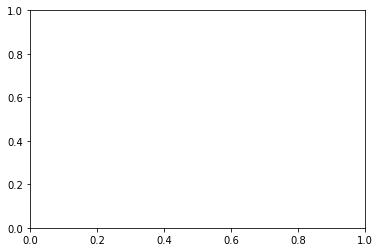

In [25]:
plt.scatter(y_test,y_pred)

In [ ]:
xgb_transformer.output_path